# Table of Contents

0. Preface
  - Instructions
  - Installer
  - Imports
  - Colour scheme preview
1. 4D 
  - Animated rotating wireframe image (projected)
  - Superposed animation frames (projected)
2. 3D Net
  - Wireframe image (projected)
  - Solid cell-shaded image (projected)
  - STL
3. 2D facet nets
  - Plain
  - Solid colour (1 per facet) (WIP)

## Instructions

1. Run the initialisation cells (down to **Colour scheme preview**) exactly once, before doing anything else.
2. In the **Colour scheme preview** section, run the first cell to display a list of colour schemes. Change the value of `PREVIEW_COLOR_SCHEME` in the second cell and run it to get a preview of that colour scheme.
3. The first half of the **Parameters** cell is where you can set all the options for the output. They should be more or less self explanatory; more will be added later. Note that strange things can happen with the projection is `PERSPECTIVE_DISTANCE` is set too low.
4. Run the **Randomization** cell each time you want to generate a new viewing angle.
5. In the **Output area**, each type of output has a *preview pane* cell and a *save files* cell. Run the preview pane cell and adjust **Parameters** until you find a view you like, then run the save files cell. 
6. Files are saved to `SAVE_DIRECTORY` (which is `./output` by default). You can add a custom suffix to the filename by setting the `TAG` parameter. If `TAG` is set to the empty string, i.e. `TAG = ""`, a 4 character suffix is generated automatically. This suffix automatically changes whenver you change the parameters or regenerate the viewing angle.
7. Note that it is not possible to preview animations or STL files. For animations, ffmpeg must be installed (this should happen automatically if you are running the notebook on mybinder.org).

In [1]:
# Installer
import sys, os

# IMPORTS
sys.path.append("..")
try:
    from tope import Tope
except ImportError:
    !{sys.executable} -m pip install ..
    from tope import Tope
from tope.net import *
from tope.orth import *
from tope.graph import Graph
from tope.plot import *

import numpy as np
rng = np.random.default_rng()

import matplotlib as mpl
import matplotlib.pyplot as plt

import json, os
import itertools

DATA_DIR = os.environ.get("POLYTOPE_UNFOLDER_DATA_DIRECTORY") or "../data"

# import prepackaged data
with open(os.path.join(DATA_DIR, "polys2.json")) as fd: 
    polys = json.load(fd)
    
# and the rest
import gzip
with gzip.open(os.path.join(DATA_DIR, "474polys.json.gz"), "rt") as fd:
    polys.update(json.load(fd))

with gzip.open(os.path.join(DATA_DIR, "d30.json.gz"), "rt") as fd:
    d30 = json.load(fd)
polys.update({f"d30-{record['ID']}": record["Vertices"] for record in d30})

with open(os.path.join(DATA_DIR, "20s.json")) as fd:
    polys.update(json.load(fd))

logger.remove()

In [2]:
def create_lc(edges, color_map = "Set2", color_range=(0.25,0.75), lw=1):
    segments = []
    colors = []
    cmap = mpl.colormaps.get(color_map)
    for i, edge in enumerate(edges):
        segments.append(edge)
        crange_start = color_range[0]
        crange_step = (color_range[1]-color_range[0]) / len(edges)
        colors.append(cmap(crange_start + i*crange_step))
    return mpl.collections.LineCollection(segments, color=colors, linewidth=lw)

def get_wireframe(P: Tope, rotator, perspective_distance=10):
    rotate  = lambda e: e @ rotator
    project = lambda e: perspective_project(perspective_project(e, perspective_distance), perspective_distance)
    return list(map(project, map(rotate, P.iter_faces_as_arrays(dim=1))))

def generate_rotators(N: int, num_steps: int = 10) -> np.ndarray:
    """
    Generate num_steps evenly spaced rotations of stacked vectors.
    """
    return rotator_nd(np.arange(0, 2*np.pi, 2*np.pi / num_steps), N)

In [3]:
# Special rotation

Q4a_d = {
    "standard": np.eye(4),
    "random": random_orth(4),
    "diagonal": np.array([
        [-1,0,1,0],
        [0,-1,1,0],
        [0,0,1,0],
        [0,0,0,1]
    ])
}

Q4b_d = {
    "obverse": np.eye(4),
    "lateral": np.array([
        [0,0,1,0],
        [0,0,0,1],
        [1,0,0,0],
        [0,1,0,0]
    ]),
    "mixed": np.array([
        [1,0,0,0],
        [0,0,1,0],
        [0,1,0,0],
        [0,0,0,1]
    ]),
    "random": random_orth(4)
}

## Polytope ID listing

In [4]:
print("Available polytopes:")
print("--------------------")
for i, cm in enumerate(polys): 
    print(f"{cm:14}", end="")
    if i%8==7: print()
print()
print()
print("Note: all numbers less than 474000000 and ending in 123456 are available.")
print("Entries whose ID has the prefix 'd30-' have at least 30 facets.")

Available polytopes:
--------------------
2070          5378          5572          11471         12181         15258         17986         18676         
29828         30418         24-cell       36-cell       123456        1123456       2123456       3123456       
4123456       5123456       6123456       7123456       8123456       9123456       10123456      11123456      
12123456      13123456      14123456      15123456      16123456      17123456      18123456      19123456      
20123456      21123456      22123456      23123456      24123456      25123456      26123456      27123456      
28123456      29123456      30123456      31123456      32123456      33123456      34123456      35123456      
36123456      37123456      38123456      39123456      40123456      41123456      42123456      43123456      
44123456      45123456      46123456      47123456      48123456      49123456      50123456      51123456      
52123456      53123456      54123456      55123456    

# Colour scheme preview

In [5]:
print("Available named colors:")
print("-----------------------")
count = 0
for cm in mpl.colors.get_named_colors_mapping(): 
    if cm.startswith("xkcd:"): continue
    print(f"{cm:24}", end="")
    count += 1
    if count%5==4: print()
print("-----------------------")
print("Note: b/g/r/c/m/y/k/w are short for blue/green/red/cyan/magenta/yellow/black/white.")

Available named colors:
-----------------------
aliceblue               antiquewhite            aqua                    aquamarine              
azure                   beige                   bisque                  black                   blanchedalmond          
blue                    blueviolet              brown                   burlywood               cadetblue               
chartreuse              chocolate               coral                   cornflowerblue          cornsilk                
crimson                 cyan                    darkblue                darkcyan                darkgoldenrod           
darkgray                darkgreen               darkgrey                darkkhaki               darkmagenta             
darkolivegreen          darkorange              darkorchid              darkred                 darksalmon              
darkseagreen            darkslateblue           darkslategray           darkslategrey           darkturquoise           
darkviol

In [6]:
print("Available color schemes:")
print("------------------------")
count = 0
for cm in mpl.colors.get_named_colors_mapping(): 
    if cm.startswith("xkcd:"): continue
    print(f"{cm:20}", end="")
    count += 1
    if count%6==5: print()
print("-----------------------")
print("Note: b/g/r/c/m/y/k/w are short for blue/green/red/cyan/magenta/yellow/black/white.")

Available color schemes:
------------------------
aliceblue           antiquewhite        aqua                aquamarine          azure               
beige               bisque              black               blanchedalmond      blue                blueviolet          
brown               burlywood           cadetblue           chartreuse          chocolate           coral               
cornflowerblue      cornsilk            crimson             cyan                darkblue            darkcyan            
darkgoldenrod       darkgray            darkgreen           darkgrey            darkkhaki           darkmagenta         
darkolivegreen      darkorange          darkorchid          darkred             darksalmon          darkseagreen        
darkslateblue       darkslategray       darkslategrey       darkturquoise       darkviolet          deeppink            
deepskyblue         dimgray             dimgrey             dodgerblue          firebrick           floralwhite         
fo

#### Paste one of these strings in between the quotation marks and run this cell (Shift+Enter) to preview a colour scheme!

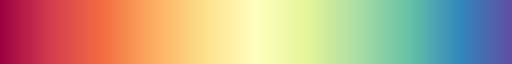

In [7]:
PREVIEW_COLOR_SCHEME = "Spectral"
mpl.colormaps.get(PREVIEW_COLOR_SCHEME)

# Parameters

In [18]:
POLYTOPE     = "d30-86363435"

COLOR_SCHEME      = "Pastel1_r"
COLOR_RANGE_BEGIN = 0.25   # between 0 and 1
COLOR_RANGE_END   = 0.75   # between 0 and 1
BG_COLOR         = "black"

PERSPECTIVE_DISTANCE = 10

DPI           = 300
ANIMATION_DPI = 150

IMAGE_FORMAT   = "svg" # or "svg" or whatever
TAG            = "" # put nonempty string here to add custom text to filenames
                    # otherwise a new tag will be generated every time this cell is run

ROTATION_AXIS = "diagonal"    # "standard" or "diagonal" or "random"
PROJECTION = "obverse" # "lateral" or "obverse" or "mixed" or "random"

ANIMATION_FPS = 20 # frame per seconds in the animation
ANIMATION_LENGTH_SECS = 3 # total length of the animation in seconds

STL_THICKNESS = 15 # thickness of frame for stl with wireframe in mm
STL_BOX_SIZE = 1000 # side of box which countains the stl with wireframe in mm (rough estimate)


# don't change ##################
SAVE_DIRECTORY = os.environ.get("POLYTOPE_UNFOLDER_OUTPUT_DIRECTORY") or "output"
os.makedirs(SAVE_DIRECTORY, exist_ok=True)

DIR_4D = os.path.join(SAVE_DIRECTORY, "4d-wireframe")
DIR_ANIMATION = os.path.join(DIR_4D, "animated")
DIR_SMEARED = os.path.join(DIR_4D, "smeared")
DIR_3D = os.path.join(SAVE_DIRECTORY, "3d-net")
DIR_STL = os.path.join(DIR_3D, "stl")
DIR_NET_PROJECTION = os.path.join(DIR_3D, "projected")
DIR_SHADED_3D_NET = os.path.join(DIR_3D, "shaded")
DIR_2D = os.path.join(SAVE_DIRECTORY, "facet-nets")
P = Tope.from_vertices(polys[POLYTOPE])
P.vertices = P.vertices.astype(float) + rng.random(size=4) # random offset

configvars = [
    POLYTOPE, COLOR_SCHEME, COLOR_RANGE_BEGIN, BG_COLOR, PERSPECTIVE_DISTANCE, DPI, ANIMATION_DPI
]

def get_tag():
    return TAG or (sum(id(v) for v in configvars)%65536).to_bytes(2,"big").hex()

# pre-rotation
ROTATION_AXIS = ROTATION_AXIS.lower().strip()
PROJECTION = PROJECTION.lower().strip()
Q4a = random_orth(4) if "random".startswith(ROTATION_AXIS) else Q4a_d[ROTATION_AXIS]
Q4b = random_orth(4) if "random".startswith(PROJECTION) else Q4b_d[PROJECTION]

# other
Q3 = random_orth(3)

# Output area

# 4D

In [9]:
def get_frames(P, before, after, num_steps=10):
    return [create_lc(get_wireframe(P, before @ rotator_nd(theta, 4) @ after)) for theta in np.arange(0, 2*np.pi, 2*np.pi / num_steps)]

In [10]:
def plot_wireframe(
    wf: list[np.ndarray], # iterable yielding 2x2 arrays
    color_map = "Pastel1_r",
    color_range = (0.25,0.75),
    weight = 1,
    bg_color = "beige",
    border = False,
    **kwargs
):
    
    fig, ax = plt.subplots()
    
    lines = create_lc(
        wf,
        color_map = color_map,
        color_range = color_range,
        lw = weight
    )

    ax.add_collection(lines)
    
    ax.autoscale()
    ax = configure_axes(ax, bg=bg_color, border=border)

    return fig, ax

### Preview 4d wireframe

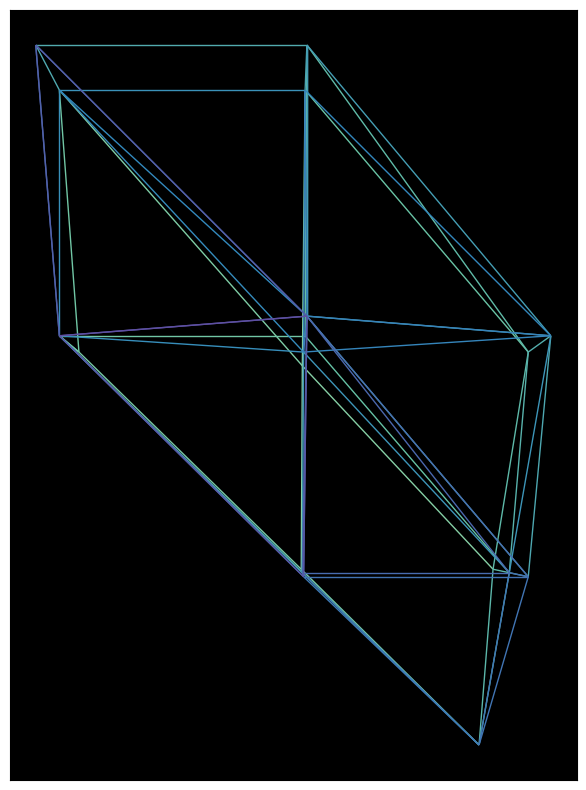

In [11]:
fig, _ = plot_wireframe(get_wireframe(P, Q4b), border=True, color_map = "Spectral", color_range=(0.75,1), bg_color=BG_COLOR)
fig.set_size_inches(10,10)

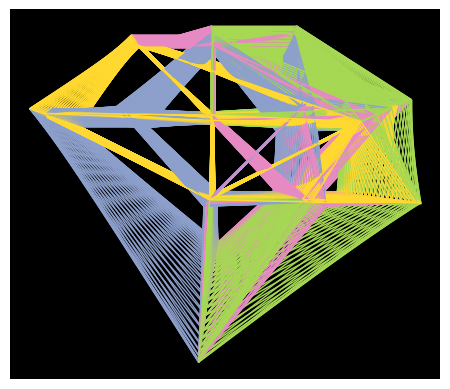

In [12]:
frames = get_frames(P, Q4a, Q4b, num_steps=ANIMATION_LENGTH_SECS*ANIMATION_FPS)
bbox = get_tightbbox(*frames) # must compute before adding artists to axes!

fig, ax = plt.subplots()
for frame in frames:
    ax.add_artist(frame)
ax.dataLim = bbox
ax = configure_axes(ax, BG_COLOR)

### Save output (smear and animation)
Make sure to run the previous cell first!

In [13]:
TAG = get_tag()

# save smear
os.makedirs(DIR_SMEARED, exist_ok=True)
fig.savefig(os.path.join(DIR_SMEARED, f"{POLYTOPE}-{TAG}.{IMAGE_FORMAT}"), dpi=DPI)

# save animation
from matplotlib.animation import ArtistAnimation
os.makedirs(DIR_ANIMATION, exist_ok=True)
animation = ArtistAnimation(fig, [[frame] for frame in frames], interval=1000/ANIMATION_FPS)
animation.save(os.path.join(DIR_ANIMATION, f"{POLYTOPE}-{TAG}.mp4"), dpi=ANIMATION_DPI)

# 3D net

In [14]:
N = P.net().unfold().in_own_span()

### Preview

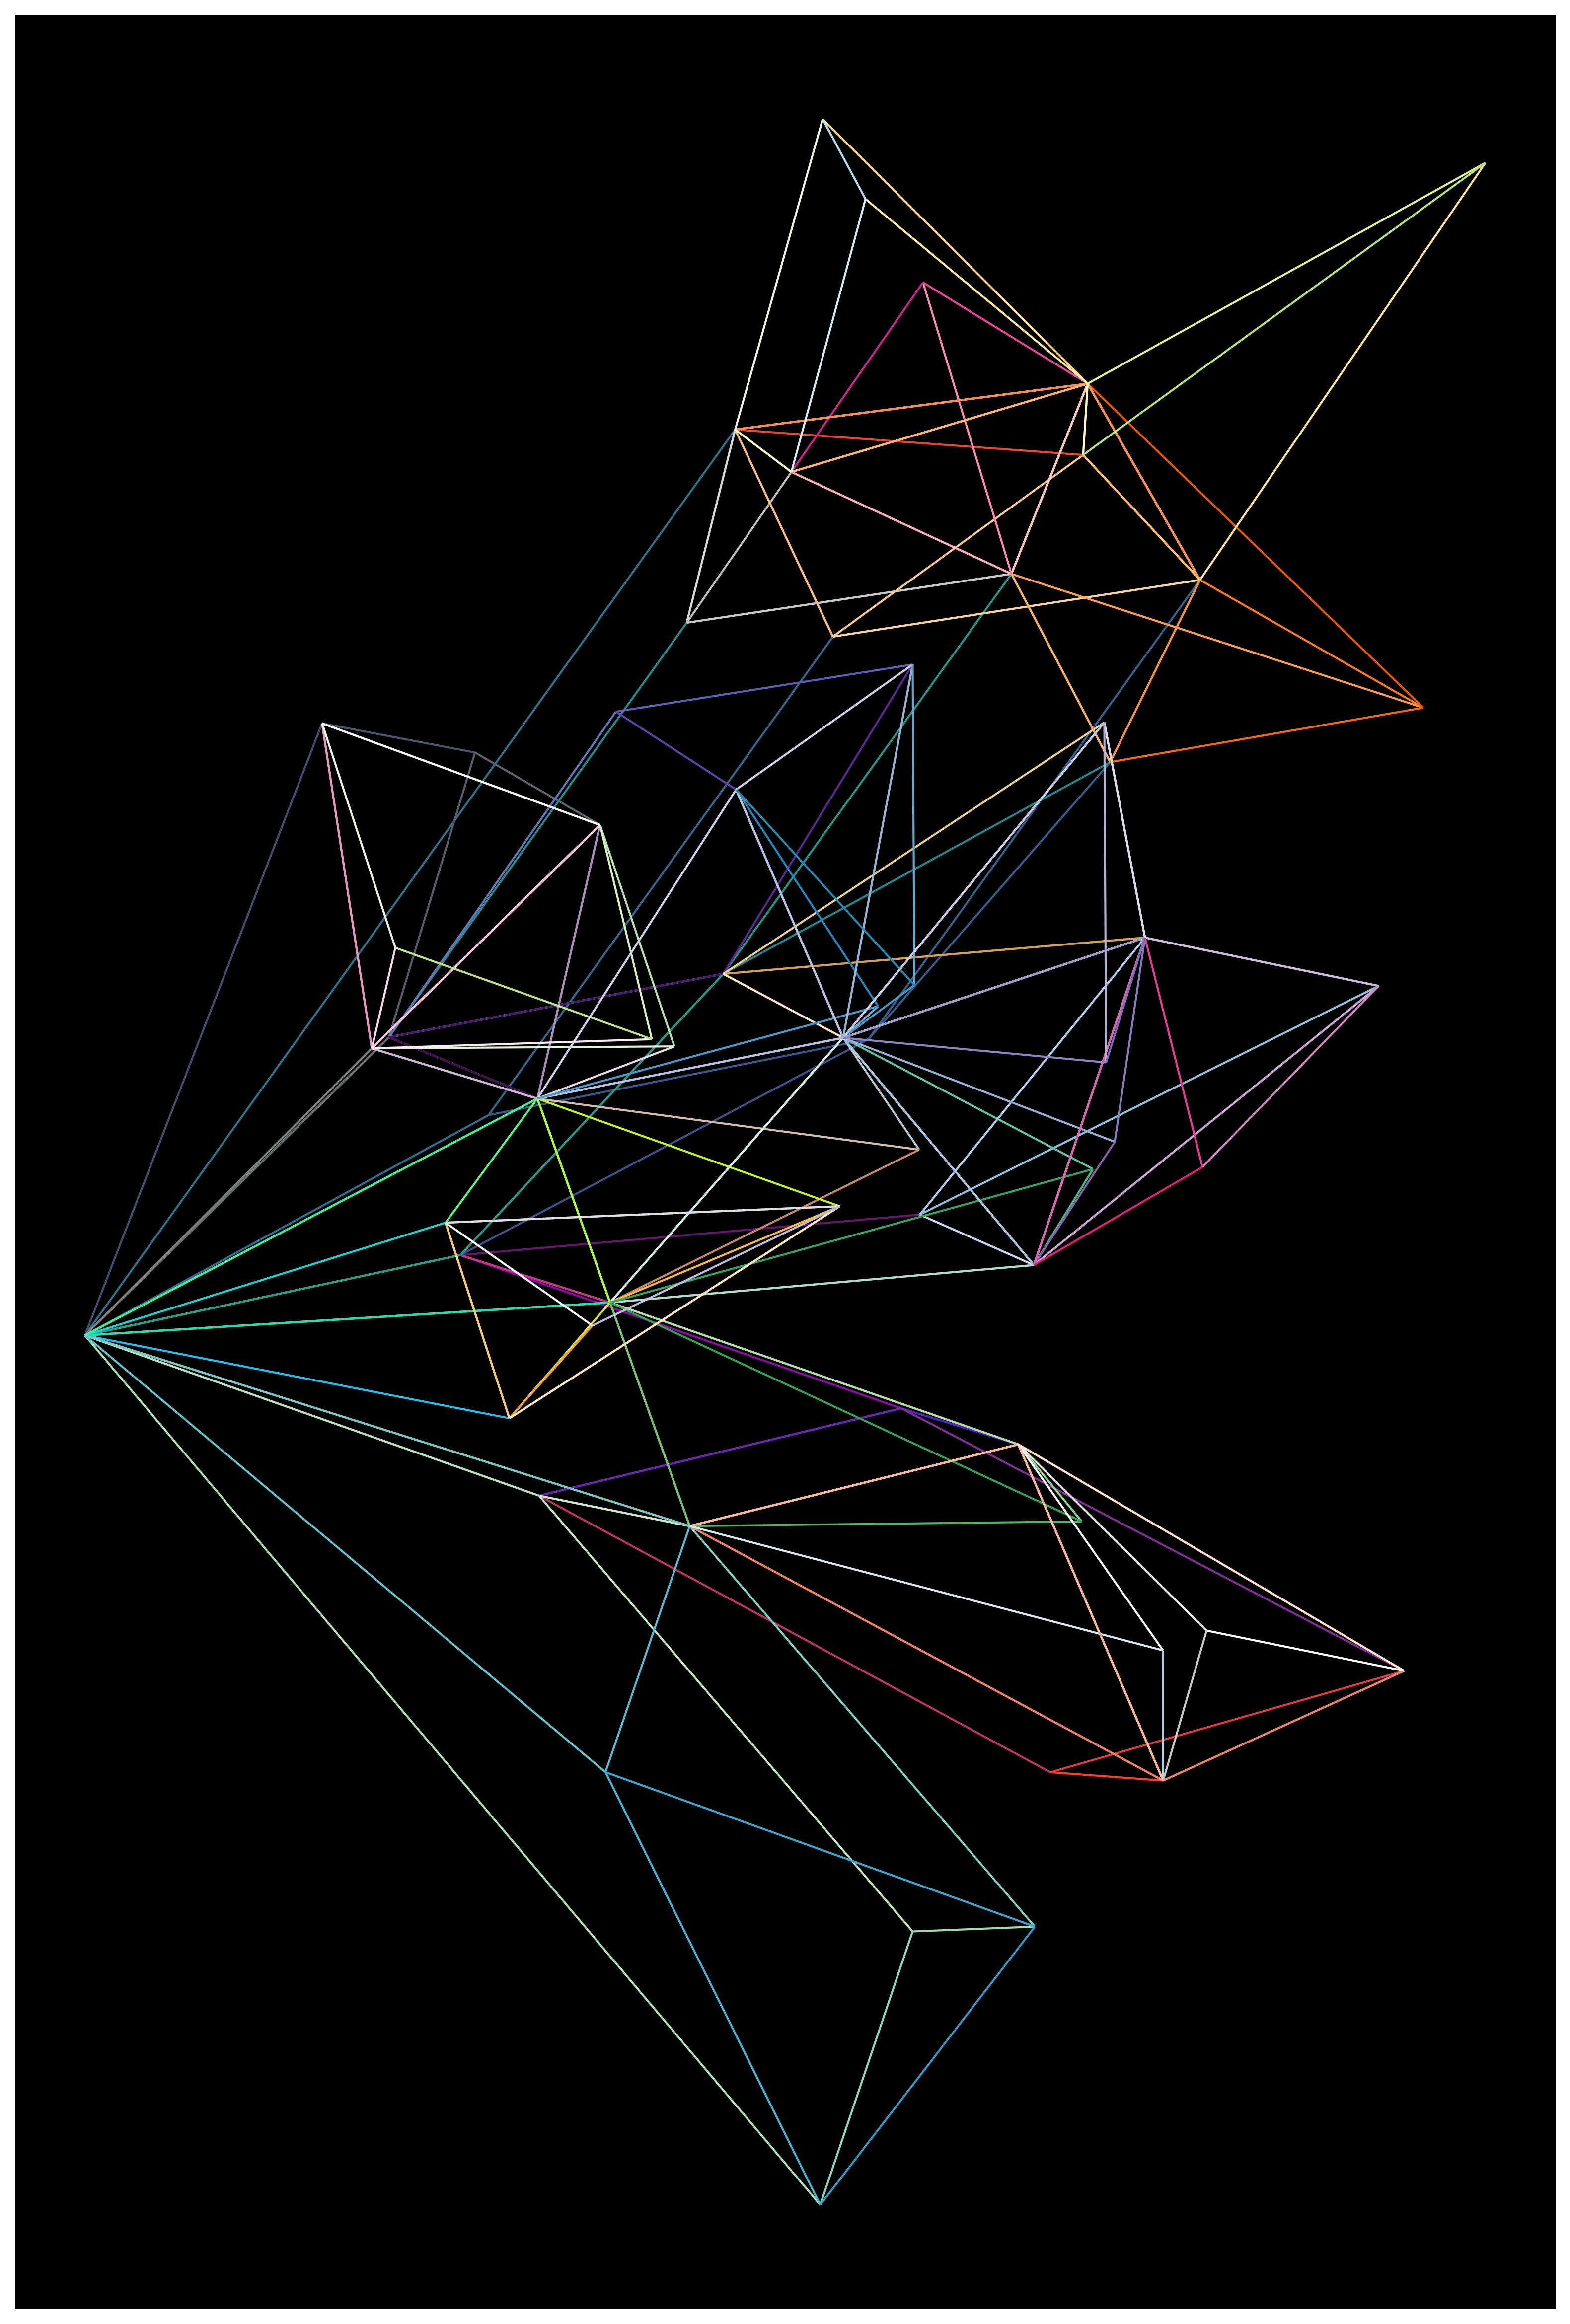

In [15]:
fig, ax = plt.subplots(dpi=DPI)

cell_edges = [np.stack([F.vertices[sorted(e)] for e in F.iter_faces(1)]) for F in N.facets.values()]
cmaps = list(mpl.colormaps)

for n, cell in enumerate(cell_edges):
    edges = perspective_project(cell @ Q3, 10)
    lc = create_lc(edges, color_map = cmaps[n%len(cmaps)])
    ax.add_collection(lc)

ax = configure_axes(ax, bg=BG_COLOR)

fig.set_size_inches(20,20)

### Save output
Make sure to run the previous cell first!

In [16]:
TAG = get_tag()

os.makedirs(DIR_NET_PROJECTION, exist_ok=True)
fig.savefig(os.path.join(DIR_NET_PROJECTION, f"{POLYTOPE}-{TAG}.{IMAGE_FORMAT}"), dpi=DPI)

## STL
Export as STL (wireframe)

In [19]:
TAG = get_tag()

from tope.stl import create_stl_from_net, stl_dimensions, define_scale
from math import sqrt

SCALE = define_scale(N, STL_BOX_SIZE, STL_THICKNESS)

t = sqrt((STL_THICKNESS/SCALE)**2/2)

thing = create_stl_from_net(N, t, walls=False)
assert thing.check()

thing.vectors = SCALE*thing.vectors

os.makedirs(DIR_STL, exist_ok=True)
thing.save(os.path.join(DIR_STL, f"{POLYTOPE}-{TAG}-wireframe.stl"))

# Print the dimensions
stl_dimensions(thing)

Model dimensions:
X dimension: 989.32 mm
Y dimension: 974.88 mm
Z dimension: 962.66 mm


X-ray STL plot

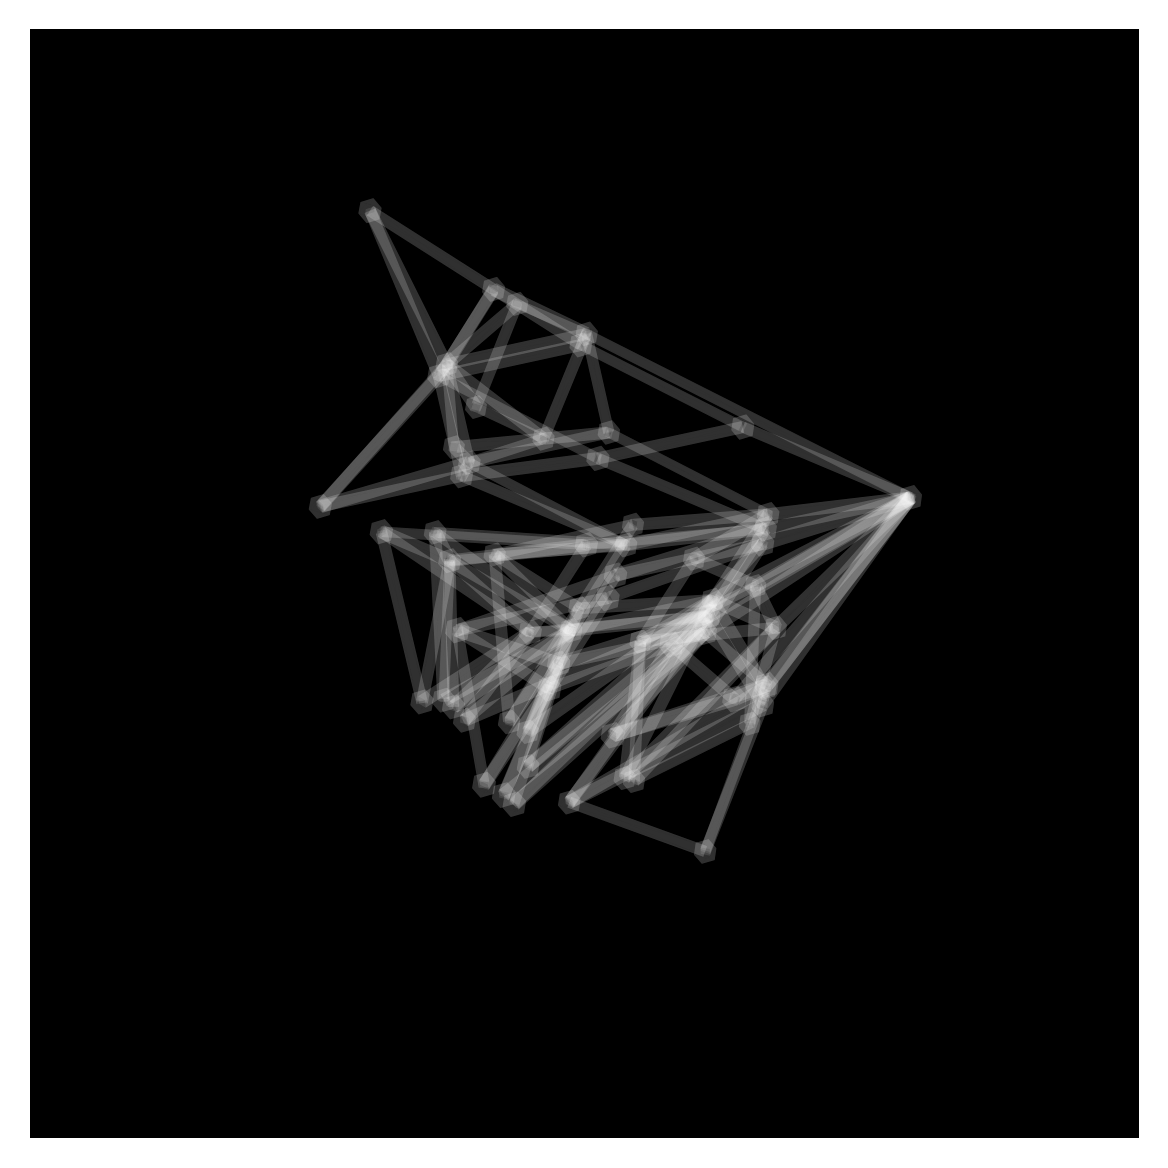

In [21]:
import mpl_toolkits.mplot3d as mpl3d

ar = mpl3d.art3d.Poly3DCollection(thing.vectors, lightsource=mpl.colors.LightSource(),facecolors='w', linewidths=1, alpha = 0.1)
fig = plt.figure(dpi=DPI)
ax = fig.add_subplot(projection='3d')
ax.add_artist(ar)

ax = configure_axes_3d(ax, thing.vectors, bg=BG_COLOR)

Export as STl (walls)

In [19]:
TAG = get_tag()

from tope.stl import create_stl_from_net
thing = create_stl_from_net(N, STL_THICKNESS, walls=True)
assert thing.check()

os.makedirs(DIR_STL, exist_ok=True)
thing.save(os.path.join(DIR_STL, f"{POLYTOPE}-{TAG}.stl"))

## Experimental: shaded 3d net

In [20]:
l = list(N.facets.values())
facet_colors = [mpl.colormaps[COLOR_SCHEME](k/len(l)) for k in range(len(l)) for _ in l[k].triangulate()]

### Preview

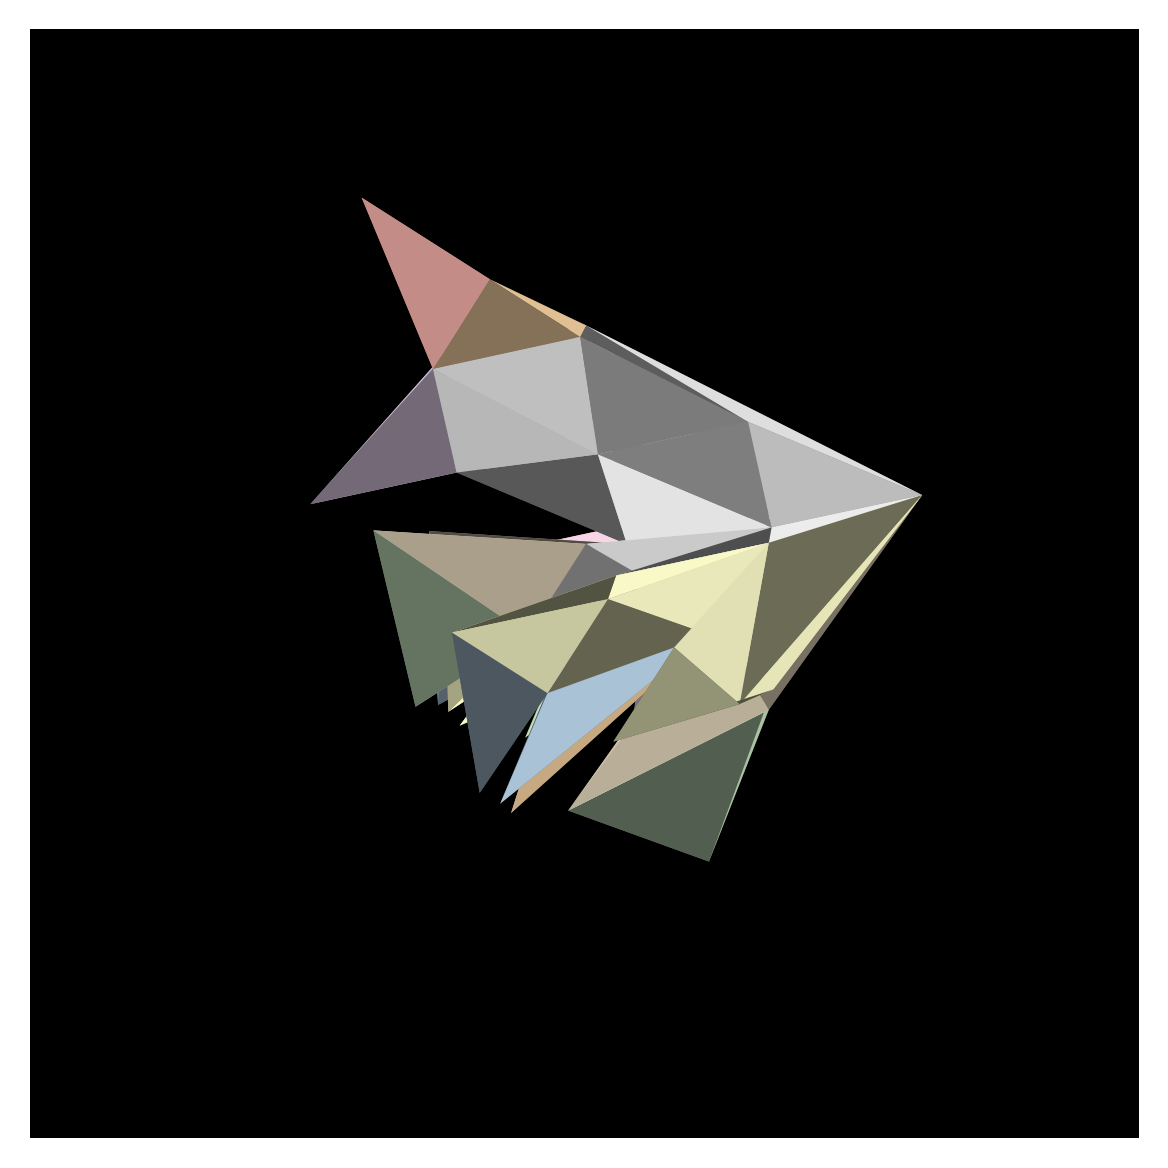

In [43]:
import mpl_toolkits.mplot3d as mpl3d

ar = mpl3d.art3d.Poly3DCollection(thing.vectors, shade=True, lightsource=mpl.colors.LightSource(), facecolors=facet_colors)
fig = plt.figure(dpi=DPI)
ax = fig.add_subplot(projection='3d')
ax.add_artist(ar)

ax = configure_axes_3d(ax, thing.vectors, bg=BG_COLOR)

### Save

In [ ]:
TAG = get_tag()

os.makedirs(DIR_SHADED_3D_NET, exist_ok=True)
fig.savefig(os.path.join(DIR_SHADED_3D_NET, f"{POLYTOPE}-{TAG}.{IMAGE_FORMAT}"), dpi=DPI)

# 2d nets

In [ ]:
facets = [P.get_facet(i) for i in range(len(P.faces[P.dim-1]))]
facet_nets = [F.net().unfold().in_own_span() for F in facets]

### Preview pane

In [ ]:
lcs = [create_lc(list(net.iter_edges())) for net in facet_nets]

# preview nets in approximately square grid
h = int(np.ceil(np.sqrt(len(facets))))
fig, axs = plt.subplots(h, h, figsize=(h*5,h*5))
axs = list(itertools.chain(*axs))

# hide and discard unused axes
for _ in range(len(axs)-len(lcs)):
    axs.pop().set_visible(False)

# now display
for ax, lc in zip(axs, lcs):
    ax.add_collection(lc)
    configure_axes(ax, bg=BG_COLOR)

### Save PNGs

In [ ]:
TAG = get_tag()

os.makedirs(DIR_2D, exist_ok=True)

savedir = os.path.join(DIR_2D, f"{POLYTOPE}-{TAG}")
os.makedirs(savedir, exist_ok=True)
for n, ax in enumerate(axs):
    save_subplot(fig, ax, os.path.join(savedir, f"{n}.{IMAGE_FORMAT}"), dpi=DPI)